# Overview

PySA-ZA does not currently include a maintenance scheduling optimiser. Therefore planned and unplanned outages must be specified on either a monthly or weekly basis. This notebook is used to prepare the outage data that is used in the model_file.

In [67]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# The Eskom data portal provides Total Planned (PCLF) and Unplanned Outages (UCLF + OCLF) for each hour for the installed Eskom fleet.
eskom_data = pd.read_csv("../data/bundle/Eskom/ESK3060_cleaned.csv",index_col=0, parse_dates=True)

# Planned outages

In [52]:
def avg_and_ffill(df, by):
    df_avg = df.resample(by).mean()

    if by == 'M':
        df_avg.index = df_avg.index.to_period('M').to_timestamp('M') - pd.offsets.MonthBegin(1)

    start_date = df.index.min().strftime('%Y-01-01')
    end_date = df.index.max().strftime('%Y-12-31 23:00:00')
    idx = pd.date_range(start=start_date, end=end_date, freq='H')
    return df_avg.reindex(idx, method='ffill')

def add_noise(df, std_dev, steps):
    noise = pd.Series(index=df.index, dtype=float)
    idxs = noise.iloc[::steps].index
    noise.loc[idxs] = df.loc[idxs] + np.random.normal(loc=0, scale=std_dev, size=len(idxs))
    return noise.interpolate()

In [59]:
pclf = eskom_data.loc["2019", "Total PCLF"]/eskom_data.loc["2019", "Installed Eskom Capacity"]
pclf_avg_mntly = avg_and_ffill(pclf, "M")
pclf_avg_wkly = avg_and_ffill(pclf, "W")

pclf_std_dev_mntly = (pclf- pclf_avg_mntly).std()
pclf_std_dev_wkly = (pclf- pclf_avg_wkly).std()

# Unplanned outages

In [71]:
uoclf = eskom_data.loc["2019", ["Total UCLF", "Total OCLF"]].sum(axis=1)/eskom_data.loc["2019", "Installed Eskom Capacity"]
uoclf_avg_mntly = avg_and_ffill(uoclf, "M")
uoclf_avg_wkly = avg_and_ffill(uoclf, "W")

ouclf_std_dev_mntly = (uoclf- uoclf.mean()).std()
ouclf_std_dev_wkly = (uoclf- uoclf.mean()).std()

(0.0, 0.4)

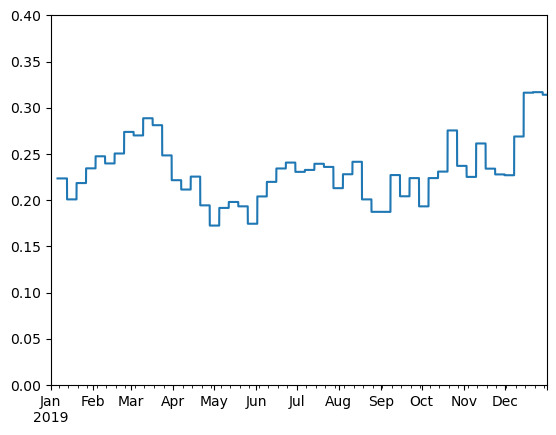

In [72]:
uoclf_avg_wkly.plot()
plt.ylim(0, 0.4)

<Axes: >

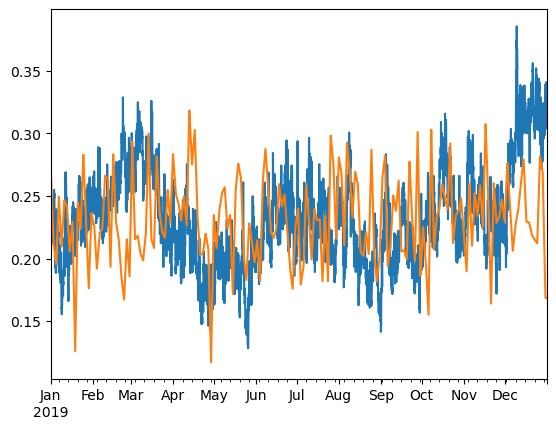

In [77]:
uoclf.plot()
add_noise(pd.Series(uoclf.mean(), index = uoclf.index), 0.04, 48).plot()

In [73]:
ouclf_std_dev_mntly
ouclf_std_dev_wkly 

0.039130952410250636